# multiway CCA
This notebook contains testing code for multi-way CCA based learning using a parafac tensor decomposition in the algorithm core, rather than a SVD

In [4]:
import numpy as np
from mindaffectBCI.decoder.offline.datasets import get_dataset
from mindaffectBCI.decoder.model_fitting import MultiCCA
from mindaffectBCI.decoder.decodingCurveSupervised import decodingCurveSupervised
from mindaffectBCI.decoder.utils import block_permute
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from mindaffectBCI.decoder.analyse_datasets import analyse_dataset, analyse_datasets, debug_test_dataset, debug_test_single_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# load example data
dataset_loader, files, dataroot = get_dataset('plos_one', regexp='s3')
evttypes=('re','fe')
tau_ms = 450

In [117]:
# level threshold - single outputs with multiple levels
dataset_loader, files, dataroot = get_dataset('mindaffectBCI',exptdir="~/Desktop/khash",regexp='vep_threshold')
evttypes='hot-on'
tau_ms = 550

In [6]:
# visual - acuity - multiple outputs at the same time.
dataset_loader, files, dataroot = get_dataset('mindaffectBCI',exptdir="~/Desktop/mark",regexp='vep_threshold_scale')
evttypes='hot-on' #'output2event'
tau_ms = 550

In [7]:
# the data
savefile = files[-1]
X,Y,coords = dataset_loader(savefile)
fs=coords[1]['fs']
ch_names=coords[-1]['coords']

Loading C:\Users\Developer/Desktop/mark\mindaffectBCI_vep_threshold_scale_201216_1503.txt
X=(237266, 8) @250.50100200400803Hz
preFilter: 6th butter ((45, 65), (5.5, 25, 'bandpass'))Hz & downsample 250.50100200400803->100Hz
resample: 250.50100200400803->100.20040080160321hz rsrate=2.5
Y=(94907, 2) @100.20040080160321Hz
60 trl_dur (ms) : [ 4000.  4000.  4000.  4000.  4000.  4000.  4000.  4000.  4001.  4000.
 10000. 10000. 10000. 10016. 10000. 10000. 10000.  9999. 10000. 10000.
 10000. 10000. 10000. 10000.  9999. 10000. 10000.  9999. 10017. 10000.
 10000.  9999. 10000.  9999.  9999. 10000. 10000. 10000. 10000.  9999.
 10000. 10000.  9999. 10000. 10000.  9999. 10000.  9999.  9999. 10000.
 10000. 10000.  9999. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
61 trl_stim : [array([241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 601, 601, 601,
       601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601,
       601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601,
    

In [8]:
# dataset specific pre-processing..
if 'visual_acuity' in savefile: # strip the calibration trials as they have a different meaning for objID==1
    print('Stripping first 10 trials')
    X = X[10:,...] 
    Y = Y[10:,...,1:]
elif 'threshold' in savefile:
    print("Adding virtual outputs")
    # add virtual outputs so always at least 30 outputs so we can test the decoding performance
    oY  = Y.copy()
    Y = np.concatenate((Y, block_permute(Y, -30, axis=-1)), -1) # (..., nY)
    Y.shape

Adding virtual outputs


EEG: X(['trial', 'time', 'channel'])(50, 509, 8) @100.22550739163117Hz
STIMULUS: Y(['trial', 'time', 'output'])(50, 509, 36)


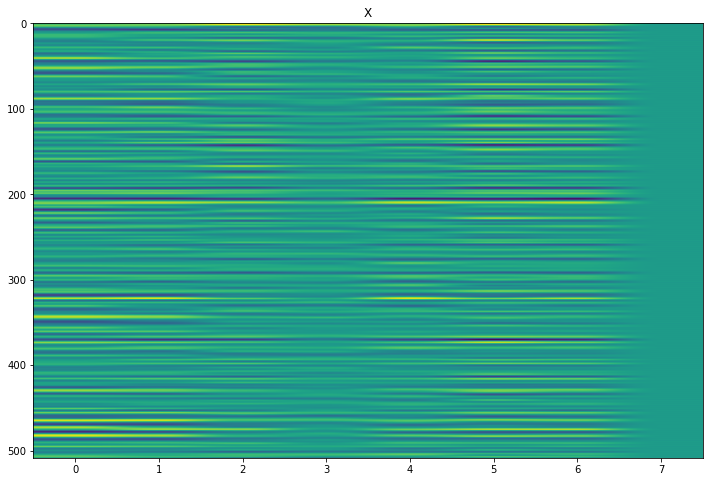

Text(0.5, 1.0, 'Y')

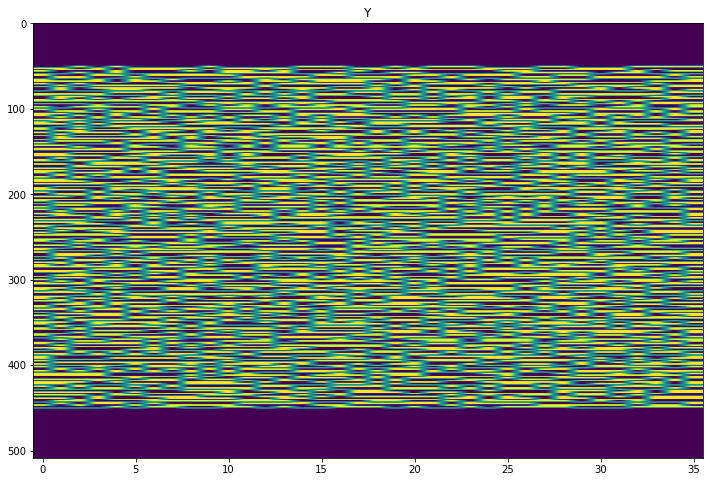

In [151]:
# output is: X=eeg, Y=stimulus, coords=meta-info about dimensions of X and Y
print("EEG: X({}){} @{}Hz".format([c['name'] for c in coords],X.shape,coords[1]['fs']))                            
print("STIMULUS: Y({}){}".format([c['name'] for c in coords[:-1]]+['output'],Y.shape))
plt.imshow(X[0,:,:],aspect='auto');plt.title('X');plt.show()
plt.imshow(Y[0,:,:],aspect='auto');plt.title('Y')

In [9]:
# get the true-label and convert to brain-response
from stim2event import stim2event
# map to event sequence, for rising/falling edges
Y,evtlabs = stim2event(oY,evtypes=evttypes,axis=-2) # (tr,samp,nY,e)
print("Evtlabs: {}".format(evtlabs))
# extract the true target to fit to, using horible slicing trick
Y_true = Y[..., 0:1, :] #  (tr,samp,1,e)
print("Y_true={}".format(Y_true.shape))
plt.imshow(Y_true[0,:,0,:].T,aspect='auto',origin='normal')

ValueError: invalid literal for int() with base 10: '-on'

Cxx=(8, 8)
Cxy=(1, 36, 55, 8)
Cyy=(1, 36, 55, 36, 55)


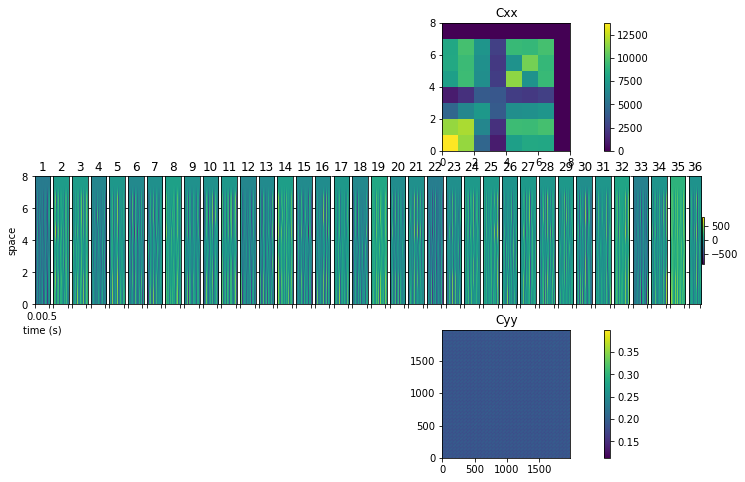

In [154]:
# get the summary statistics
from updateSummaryStatistics import updateSummaryStatistics, plot_summary_statistics
tau = tau_ms * fs // 1000 # ms->samples
Cxx, Cxy, Cyy = updateSummaryStatistics(X, Y_true, tau=tau)
print("Cxx={}".format(Cxx.shape))
print("Cxy={}".format(Cxy.shape))
print("Cyy={}".format(Cyy.shape))
plot_summary_statistics(Cxx, Cxy, Cyy, evtlabs=evtlabs, fs=fs, ch_names=ch_names)

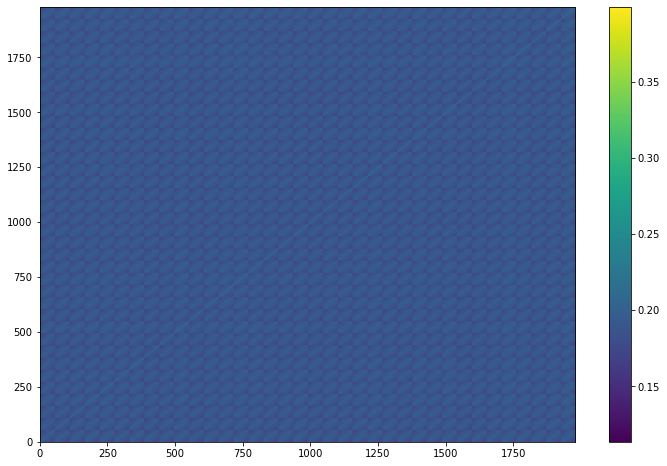

In [155]:
plt.imshow(Cyy.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto',origin='normal');plt.colorbar()

In [156]:
rank=2

A=(2, 8) R=(2, 36, 55)


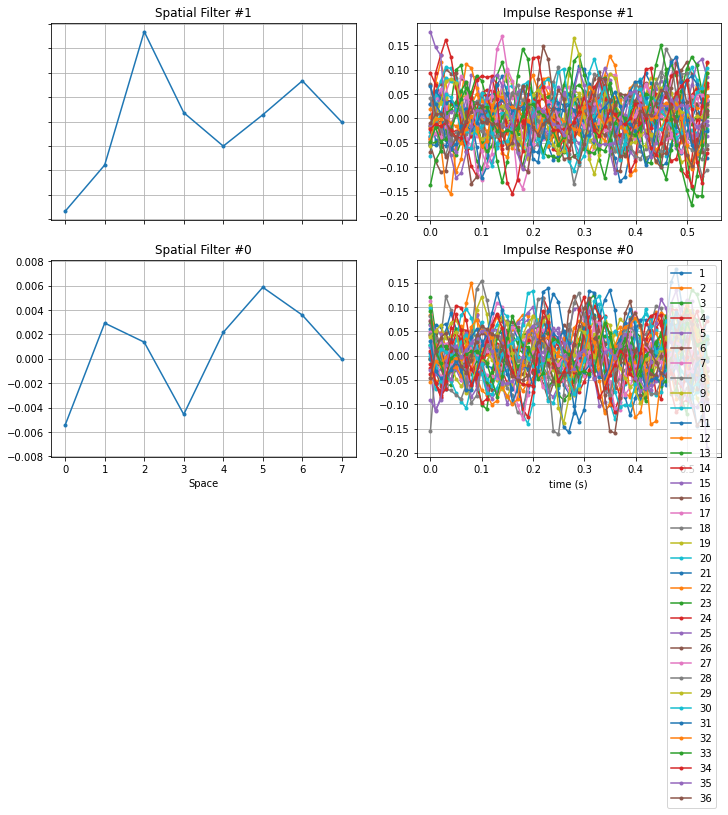

Int Lens:..............................

            IntLen    67   135   186   254   322   373   441   509 
              Perr  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   AUDC  0.0
         Perr(est)  -0.00  0.00  -0.00  -0.00  0.00  -0.00  0.00  0.00   PSAE 100.1
           StopErr  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   AUSC  0.0
     StopThresh(P)  -0.00  -0.00  -0.00  -0.00  -0.00  -0.00  -0.00  -0.00   SSAE  0.0



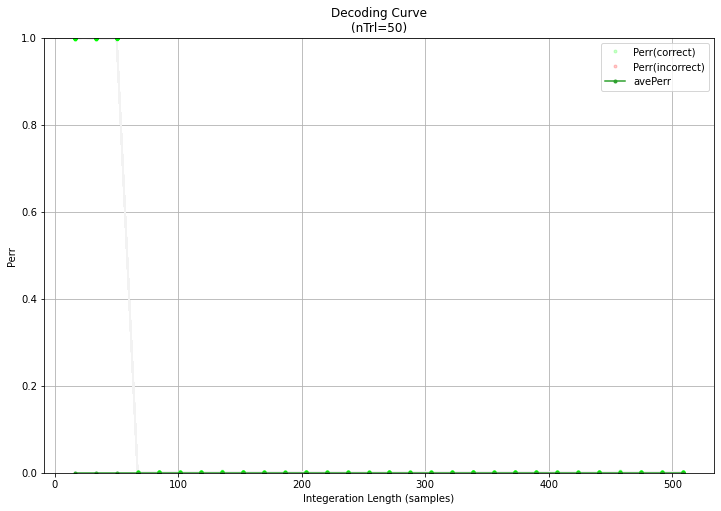

In [157]:
from multipleCCA import multipleCCA, robust_whitener
from updateSummaryStatistics import plot_factoredmodel
# run and plot the normal CCA model
J, W, R = multipleCCA(Cxx, Cxy, Cyy, reg=.02, rank=rank)
plot_factoredmodel(W, R, ch_names=ch_names, fs=fs, evtlabs=evtlabs);plt.show()
# eval this models performance
from scoreStimulus import scoreStimulus
Fe = scoreStimulus(X, W, R)
from scoreOutput import scoreOutput
Fy = scoreOutput(Fe, Y, R=R, dedup0=True) # (nM,nTrl,nEp,nY)
from decodingCurveSupervised import decodingCurveSupervised, plot_decoding_curve
dc=decodingCurveSupervised(Fy)
plot_decoding_curve(*dc)

In [122]:
# Now try with the tensor factored version..

Text(0.5, 1.0, 'Whitened: Cxx')

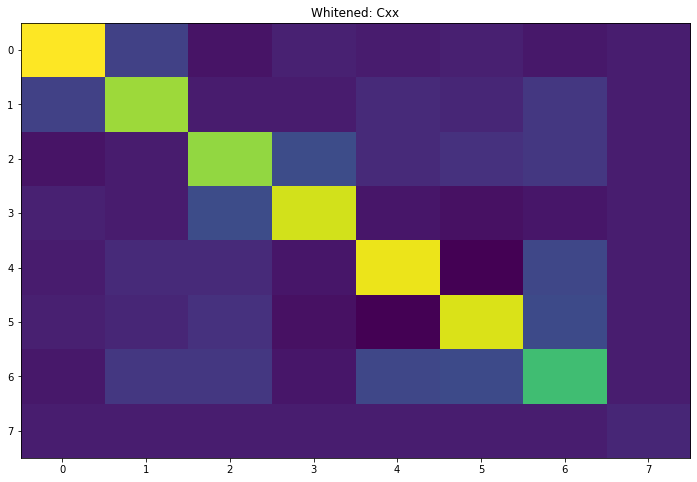

In [158]:
# 1. X spatial whitener
from multipleCCA import robust_whitener
Wx, iWx = robust_whitener(Cxx,reg=.02)

wCxxw = np.einsum("de,df,eg",Cxx,Wx,Wx)
plt.imshow(wCxxw,aspect='auto');plt.title('Whitened: Cxx')

In [159]:
# 2.Cyy combined whitener..
#  Cyy = (nM,e,tau,e,tau)
Wy, iWy = robust_whitener(Cyy.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),reg=.02) # (e*tau,e*tau)
Wy = Wy.reshape(Cyy.shape[1:]) # (e,tau,e,tau)
iWy = iWy.reshape(Cyy.shape[1:]) # (e,tau,e,tau)

In [160]:
# 2. Y temporal whitener
#  Cyy = (nM,e,tau,e,tau)
Cyy_tau = np.sum(Cyy,axis=(0,1,3))
#plt.imshow(Cyy_tau,aspect='auto');plt.title('Cyy_tau');plt.colorbar();plt.show()
Wy_tau, iWy_tau = robust_whitener(Cyy_tau,reg=.0)

#wtauCyy_tauwtau = np.einsum("tu,tv,uw",Cyy_tau,Wy_tau,Wy_tau)
#plt.imshow(wtauCyy_tauwtau,aspect='auto');plt.title('Whitended: Cyy_tau');plt.colorbar();plt.show()

#wtauCyywtau = np.einsum("metfu,tv,uw->mevfw",Cyy,Wy_tau,Wy_tau)
#plt.imshow(wtauCyywtau.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.title('Tau Whitened: Cyy')

In [161]:
# 2. Y event whitener
#  Cyy = (nM,e,tau,e,tau)
Cyy_e = np.sum(Cyy,axis=(0,2,4))
Wy_e, iWy_e = robust_whitener(Cyy_e,reg=.02)

#weCyy_ewe = np.einsum("ed,ef,dg",Cyy_e,Wy_e,Wy_e)
#plt.imshow(weCyy_ewe,aspect='auto');plt.title('Whitended: Cyy_tau');plt.show()

#wtauCyywtau = np.einsum("metfu,tv,uw->mevfw",Cyy,Wy_tau,Wy_tau)
#plt.imshow(wtauCyywtau.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.title('Tau Whitened: Cyy')

In [167]:
def plotCxy(Cxy):
    fit,ax = plt.subplots(nrows=1,ncols=Cxy.shape[1],sharey='row')
    for ei in range(Cxy.shape[1]):
        plt.sca(ax[ei])
        plt.imshow(Cxy[0,ei,:,:],aspect='auto')

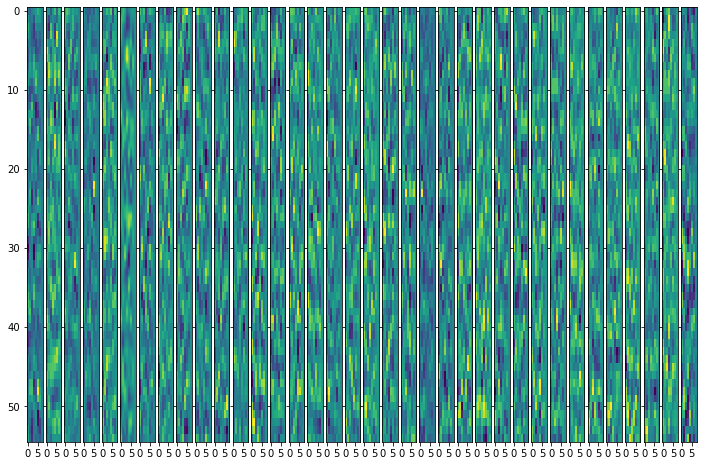

In [168]:
# apply the spatial whiteners
WxCxy = np.einsum("metd,df->metf",Cxy,Wx)
plotCxy(WxCxy)

In [187]:
# set factored/nonfactored
isFactored = False

WxCxyWy (1, 36, 55, 8)


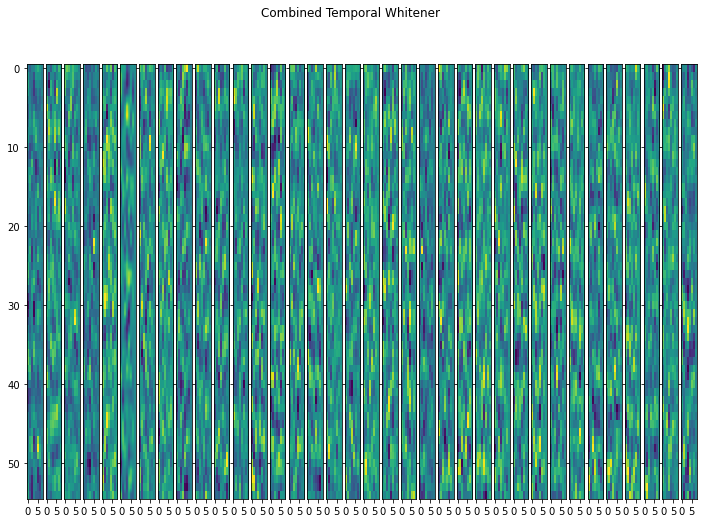

In [188]:
# total-temporal-whitener
if not isFactored:
    WxCxyWy_t = np.einsum("metd,etgu->mgud",WxCxy,Wy)

    print("WxCxyWy {}".format(WxCxyWy_t.shape))
    plotCxy(WxCxyWy_t); plt.suptitle("Combined Temporal Whitener")

In [189]:
# factored-whitener
if isFactored:
    WxCxyWy_f = np.einsum("metd,eg,tu->mgud",WxCxy,Wy_e,Wy_tau)

    print("WxCxyWy {}".format(WxCxyWy_f.shape))
    plotCxy(WxCxyWy_f); plt.suptitle("Factored Temporal Whitener")

ten=(36, 55, 8)


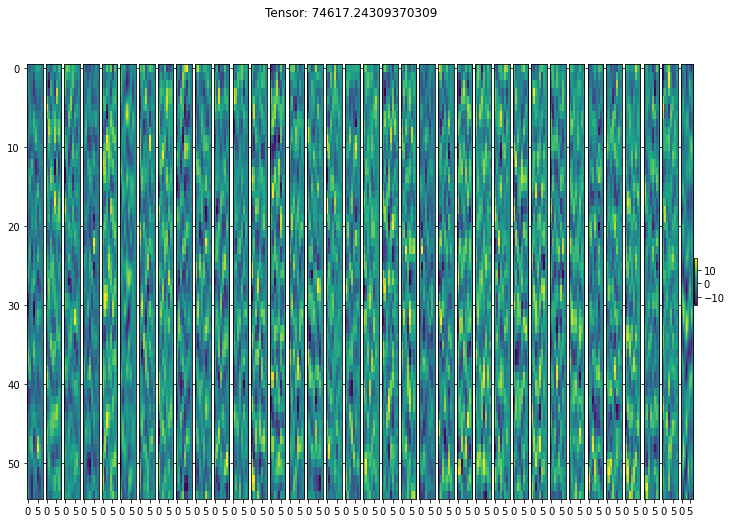

Decomp=(36, 10),(55, 10),(8, 10)
w=[860.53856158 543.21065108 281.55235549 533.70892316 135.58498037
 203.09683448 276.51024087 228.46924347 313.3471116  228.36913089]
recons=(36, 55, 8)


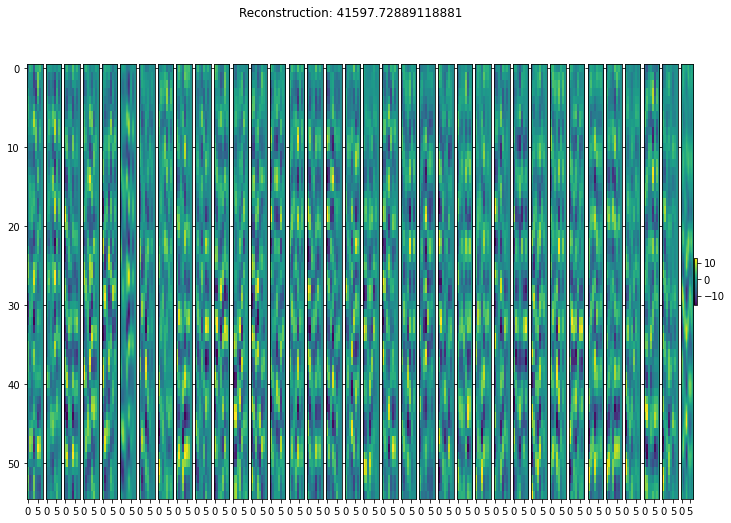

|W|=74617.24309370309 |parafac|=41597.72889118881


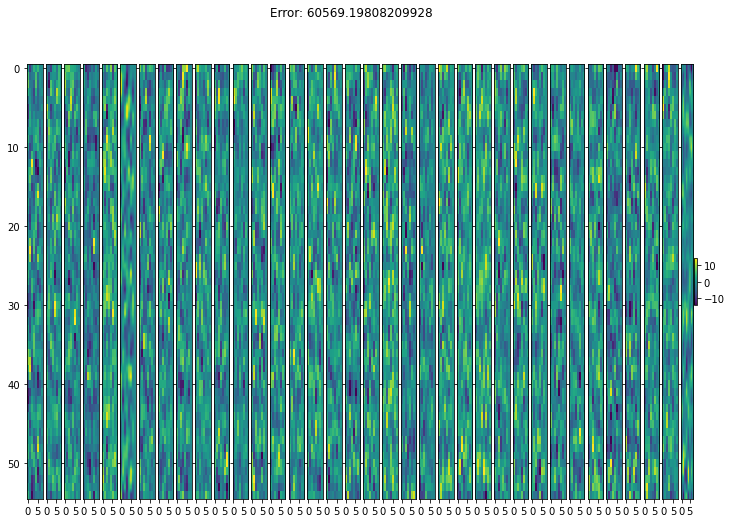

|err|=60569.19808209928


In [198]:
# CD/PARAFAC decomp
from tensorly.decomposition import parafac
if isFactored: 
    ten = WxCxyWy_f[0,...]
else:
    ten = WxCxyWy_t[0,...]
print("ten={}".format(ten.shape))
normW = np.sum(np.abs(ten.ravel()))
plotCxy(ten[np.newaxis,...]); plt.colorbar();plt.suptitle("Tensor: {}".format(normW)); plt.show()
kruskal_decomp = parafac(ten, rank=10, normalize_factors=True)
weight = kruskal_decomp[0]
factors = kruskal_decomp[1]
print("Decomp={},{},{}".format(*[f.shape for f in factors]))
We = factors[0]
Wt = factors[1]
Wd = factors[2]
print("w={}".format(weight))

# check the reconstruction error
from tensorly import kruskal_to_tensor
recons = kruskal_to_tensor(kruskal_decomp)
normRecons = np.sum(np.abs(recons.ravel()))
print('recons={}'.format(recons.shape))
plotCxy(recons[np.newaxis,...]); plt.colorbar(); plt.suptitle("Reconstruction: {}".format(normRecons)); plt.show()
err = np.sum(np.abs(ten.ravel()-recons.ravel()))
print('|W|={} |parafac|={}'.format(normW,normRecons,err))

plotCxy((ten-recons)[np.newaxis,...]); plt.colorbar(); plt.suptitle("Error: {}".format(err)); plt.show()
print('|err|={}'.format(err))


Text(0.5, 0.98, '_visual_acuity_201210_1559.txt evttypes=output2event')

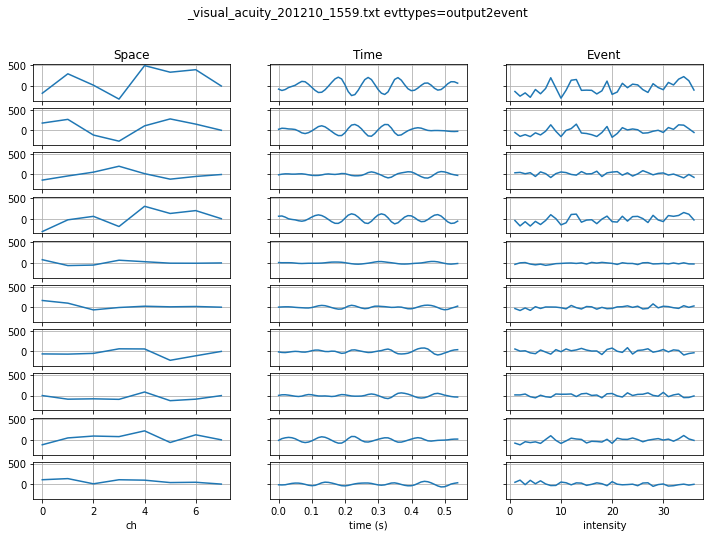

In [199]:
# plot the decomp: e,t,d x rank
ch_names = np.arange(Wd.shape[0]) if ch_names is None else ch_names
times = np.arange(Wt.shape[0])/fs
evts = evtlabs
fig, axes = plt.subplots(nrows=We.shape[1],ncols=3,sharex='col',sharey=True)
if axes.ndim<2: axes=axes[np.newaxis,:]
for r in range(We.shape[1]):
    plt.sca(axes[r,0]); plt.plot(ch_names, Wd[:,r]*weight[r]); plt.grid(); 
    if r==0: plt.title('Space');
    elif r==We.shape[1]-1: plt.xlabel('ch')
    plt.sca(axes[r,1]); plt.plot(times,    Wt[:,r]*weight[r]); plt.grid(); 
    if r==0: plt.title('Time') 
    elif r==We.shape[1]-1: plt.xlabel('time (s)')
    plt.sca(axes[r,2]); plt.plot(evts,     We[:,r]*weight[r]); plt.grid(); 
    if r==0: plt.title('Event')
    elif r==We.shape[1]-1: plt.xlabel('intensity') 
plt.suptitle("{} evttypes={}".format(files[-1][-30:],evttypes))

trying to get pos from cap file!
A=(10, 8) R=(10, 36, 55)


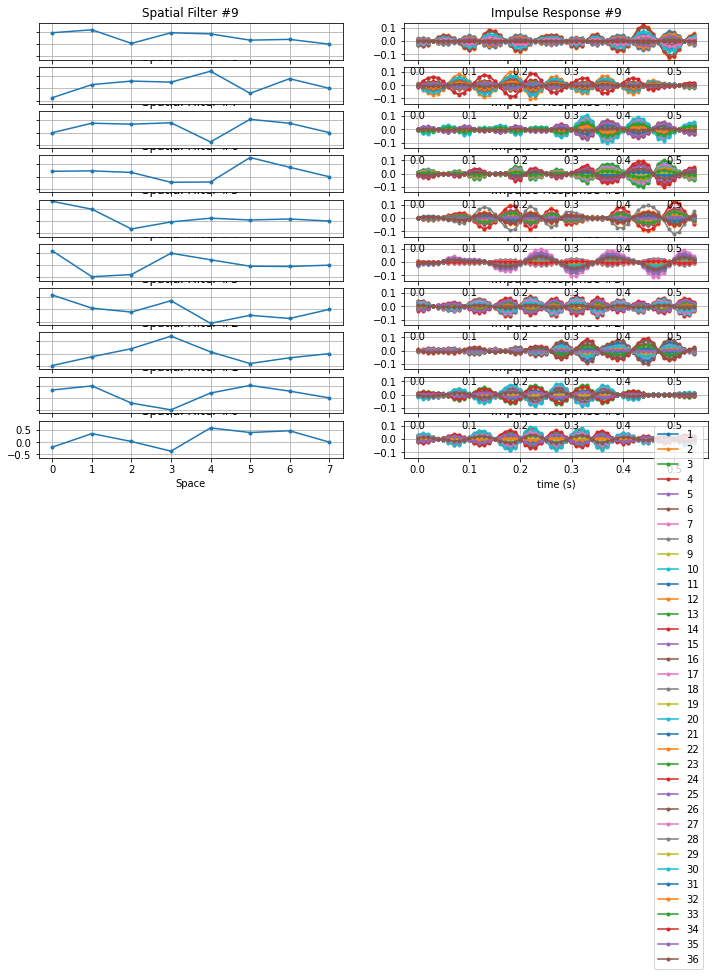

In [200]:
# make equivalent to the multiCCA outputs (so can re-use apply methods)
W = Wd.T # (rank,d)
R = np.einsum("tk,ek->ket",Wt,We) # (rank,e,tau)
plot_factoredmodel(W, R, ch_names=ch_names, fs=fs, evtlabs=evtlabs);plt.show()

In [201]:
# apply the spatial whitener
W = W @ iWx # (d,rank)

In [202]:
# include the temporal whitener
if isFactored:
    R = np.einsum("ket,ef,tu->kfu",R,iWy_e,iWy_tau)
else:
    R = np.einsum("ket,etfu->kfu",R,iWy)

Int Lens:..............................

            IntLen    67   135   186   254   322   373   441   509 
              Perr  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   AUDC  0.0
         Perr(est)  -0.00  -0.00  0.00  0.00  -0.00  0.00  0.00  -0.00   PSAE 100.1
           StopErr  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   AUSC  0.0
     StopThresh(P)  -0.00  -0.00  -0.00  -0.00  -0.00  -0.00  -0.00  -0.00   SSAE  0.1



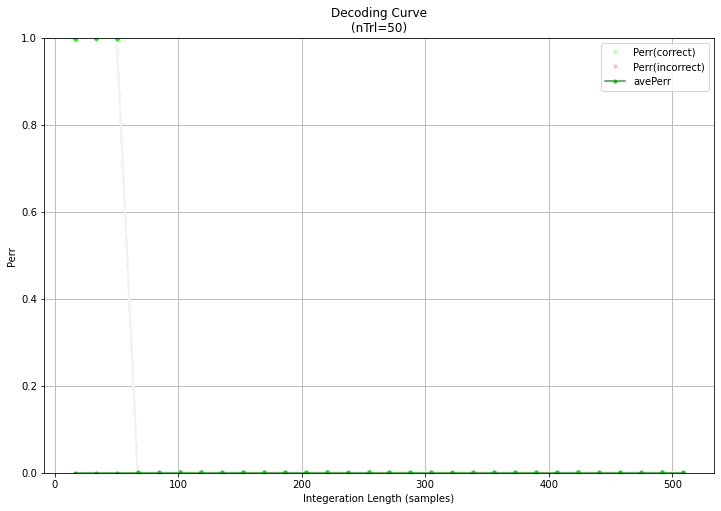

In [203]:
# apply to the data
from scoreStimulus import scoreStimulus
Fe = scoreStimulus(X, W, R)
from scoreOutput import scoreOutput
Fy = scoreOutput(Fe, Y, R=R, dedup0=True) # (nM,nTrl,nEp,nY)
from decodingCurveSupervised import decodingCurveSupervised, plot_decoding_curve
dc=decodingCurveSupervised(Fy)
plot_decoding_curve(*dc)